In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [113]:
df = pd.read_csv('../data/consolidated_data/training_dataset.csv',index_col='date')
df.drop(columns=['Unnamed: 0','state'], inplace=True)
df = df.groupby('date').sum()
df.index = pd.to_datetime(df.index)
df = df.asfreq('d')

In [114]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['cases_new'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}' )
print(f'Critical Values: {result[4]}')

ADF Statistic: -4.176908825015194
p-value: 0.0007207787314412768
Critical Values: {'1%': -3.4346453058155175, '5%': -2.8634371105641443, '10%': -2.5677799947325988}


In [118]:
split_index = int(0.5 * len(df))
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

print("Training data shape:", train_data.shape)

print("Testing data shape:", test_data.shape, test_data)

Training data shape: (774, 26)
Testing data shape: (774, 26)             cases_new  cases_recovered  cases_active  cases_unvax  cases_pvax  \
date                                                                            
2022-03-09      30246            26653        310167         4258         630   
2022-03-10      30787            26457        314427         4429         668   
2022-03-11      32800            24444        322707         4756         769   
2022-03-12      26250            25089        323791         3545         692   
2022-03-13      22535            25356        320883         3207         502   
...               ...              ...           ...          ...         ...   
2024-04-16        110               44          7736           21           1   
2024-04-17        125               40          7821           20           0   
2024-04-18        134               31          7924           12           0   
2024-04-19        135               21          

---

In [119]:
from statsmodels.tsa.seasonal import seasonal_decompose

result=seasonal_decompose(df['cases_new'], period=365)
trend = result.trend
seasonal = result.seasonal
residual = result.resid

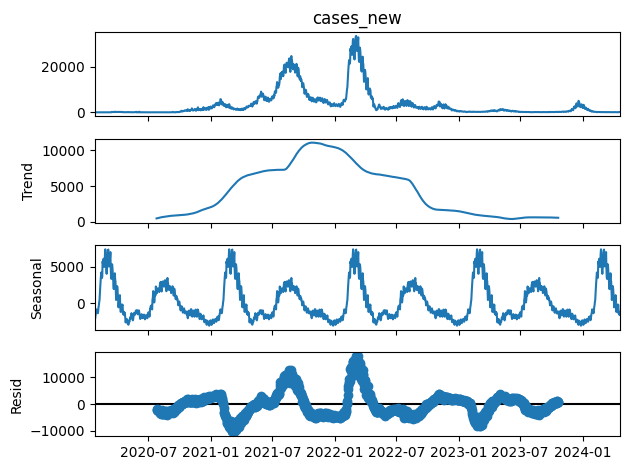

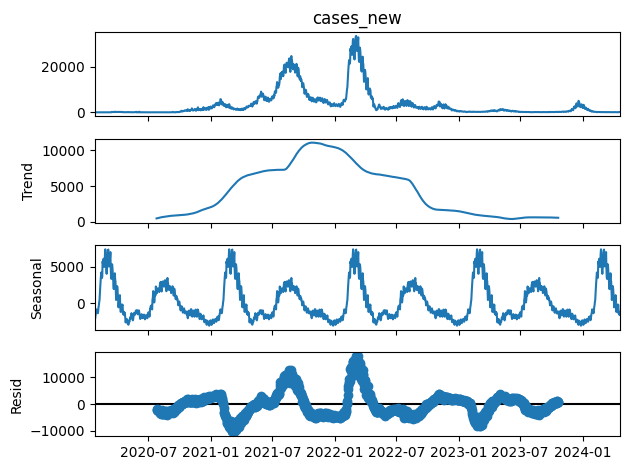

In [120]:
result.plot()

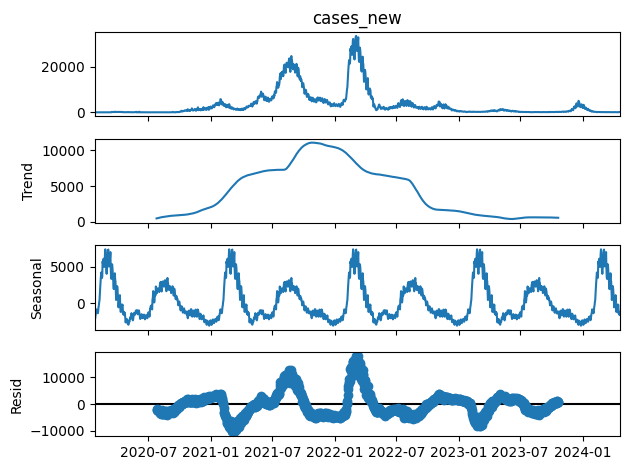

In [121]:
data_diff = df.diff()
data_diff = df.dropna()

dec = seasonal_decompose(data_diff['cases_new'],period = 365).plot()
plt.show()

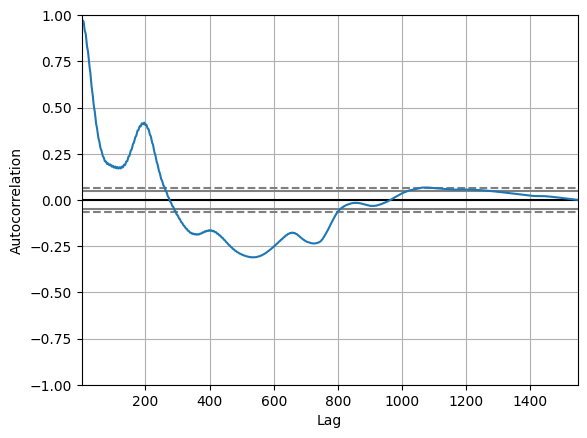

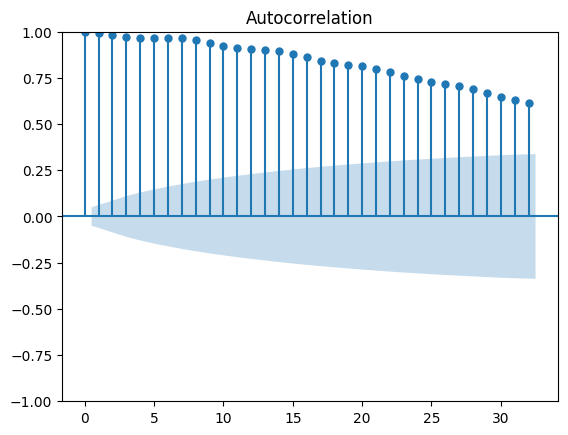

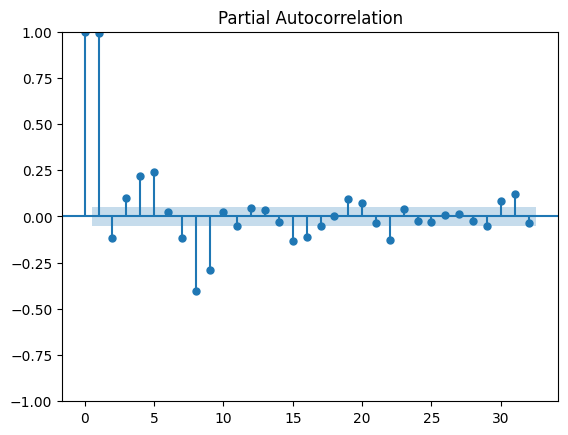

In [122]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['cases_new'])
plot_acf(df['cases_new'])
plot_pacf(df['cases_new'])
plt.show()

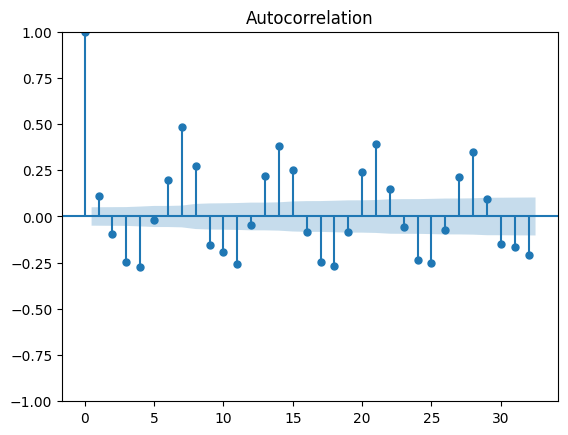

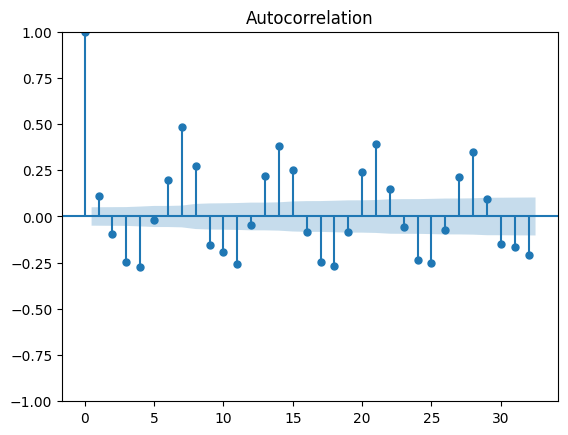

In [123]:
plot_acf(df['cases_new'].diff().dropna())

### ARIMA

In [124]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(train_data['cases_new'], 
                      m=7,                                   
                      seasonal=True,  
                      d=None,            
                      test='adf',
                      start_p=0, start_q=0,             
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=12341.516, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=12579.281, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=12412.695, Time=0.33 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=12468.358, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=12579.164, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=12466.351, Time=0.23 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=12415.055, Time=0.20 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=12341.087, Time=1.79 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=12384.686, Time=0.51 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=12342.225, Time=2.01 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=12340.547, Time=1.57 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=12442.088, Time=0.60 sec


In [98]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  603
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -4995.359
Date:                           Sun, 07 Jul 2024   AIC                           9998.719
Time:                                   23:08:40   BIC                          10016.320
Sample:                               01-01-2021   HQIC                         10005.569
                                    - 08-26-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1545      0.024     -6.373      0.000      -0.202      -0.107
ar.S.L7        0.8736      0.027     32.591      0.000       0.821       0.926
ma.S.L7       -0.5300      0.045    -11.750      0.000      -0.618      -0.442
sigma2      9.381e+05   2.72e+04     34.499      0.000    8.85e+05    9.91e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1016.81
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               5.91   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [99]:
n_periods = len(test_data)
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
forecast_index = test_data.index
print(forecast)

2022-08-27    2955.611544
2022-08-28    2270.556546
2022-08-29    2057.205785
2022-08-30    2585.956443
2022-08-31    2840.504557
                 ...     
2024-04-16    1078.771345
2024-04-17    1078.773961
2024-04-18    1078.776184
2024-04-19    1078.773872
2024-04-20    1078.772706
Freq: D, Length: 603, dtype: float64


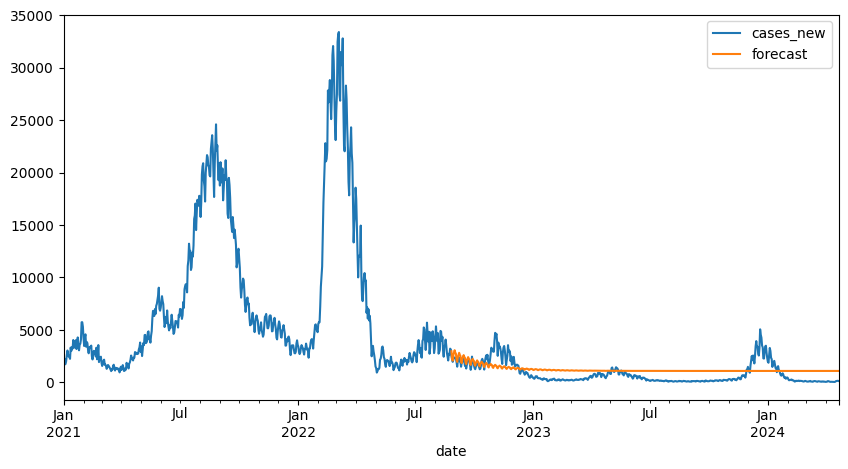

In [100]:
vis_df = df.copy()
vis_df.index = pd.to_datetime(vis_df.index)
vis_df['forecast']= forecast
vis_df[['cases_new','forecast']].plot(figsize=(10,5))
plt.show()

----

In [101]:
from prophet import Prophet

In [102]:
# Modifying df to fit prophet model

#Training Data
trainprop_df = pd.DataFrame(columns=['ds','y'])
trainprop_df['ds'] = train_data.index
trainprop_df['y'] = train_data['cases_new'].tolist()



#Testing Data
testprop_df = pd.DataFrame(columns=['ds'])
testprop_df['ds'] = test_data.index

print([trainprop_df.head(),testprop_df.head()])

[          ds     y
0 2021-01-01  2068
1 2021-01-02  2295
2 2021-01-03  1704
3 2021-01-04  1741
4 2021-01-05  2027,           ds
0 2022-08-27
1 2022-08-28
2 2022-08-29
3 2022-08-30
4 2022-08-31]


In [108]:
m = Prophet(growth = 'logistic')
trainprop_df['cap'] = df['cases_new'].max()
m.fit(trainprop_df)

23:08:51 - cmdstanpy - INFO - Chain [1] start processing
23:08:51 - cmdstanpy - INFO - Chain [1] done processing


In [109]:
testprop_df['cap'] = df['cases_new'].max()
testprop_df['floor'] = 0
forecastProphet = m.predict(testprop_df)

In [110]:
forecastProphet

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-08-27,8360.169303,33406,-1071.276684,18027.397639,8360.169303,8360.169303,277.256971,277.256971,277.256971,277.256971,277.256971,277.256971,0.0,0.0,0.0,8637.426273
1,2022-08-28,8362.308225,33406,-2013.074333,16577.218989,8362.308227,8362.308227,-534.491488,-534.491488,-534.491488,-534.491488,-534.491488,-534.491488,0.0,0.0,0.0,7827.816737
2,2022-08-29,8364.447512,33406,-2662.263646,16018.486476,8364.447499,8364.447499,-1082.205741,-1082.205741,-1082.205741,-1082.205741,-1082.205741,-1082.205741,0.0,0.0,0.0,7282.241770
3,2022-08-30,8366.587163,33406,-2058.466561,17790.415352,8366.587115,8366.587115,-294.517658,-294.517658,-294.517658,-294.517658,-294.517658,-294.517658,0.0,0.0,0.0,8072.069505
4,2022-08-31,8368.727179,33406,-368.163427,18191.444620,8368.727102,8368.727102,362.194254,362.194254,362.194254,362.194254,362.194254,362.194254,0.0,0.0,0.0,8730.921433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,2024-04-16,9702.904968,33406,1.542921,19099.484281,9689.701008,9716.243726,-294.517658,-294.517658,-294.517658,-294.517658,-294.517658,-294.517658,0.0,0.0,0.0,9408.387310
599,2024-04-17,9705.254305,33406,618.728301,19257.052737,9692.014453,9718.647538,362.194254,362.194254,362.194254,362.194254,362.194254,362.194254,0.0,0.0,0.0,10067.448559
600,2024-04-18,9707.603979,33406,1330.575494,19144.839375,9694.337808,9721.051691,667.011589,667.011589,667.011589,667.011589,667.011589,667.011589,0.0,0.0,0.0,10374.615568
601,2024-04-19,9709.953988,33406,1161.233115,19056.293519,9696.661490,9723.456193,604.752073,604.752073,604.752073,604.752073,604.752073,604.752073,0.0,0.0,0.0,10314.706061


In [111]:
forecastProphet = forecastProphet[['ds','yhat']]
forecastProphet = forecastProphet.set_index('ds')
forecastProphet

,yhat
ds,
2022-08-27,8637.426273
2022-08-28,7827.816737
2022-08-29,7282.241770
2022-08-30,8072.069505
2022-08-31,8730.921433
...,...
2024-04-16,9408.387310
2024-04-17,10067.448559
2024-04-18,10374.615568


<Axes: xlabel='date', ylabel='cases_new'>

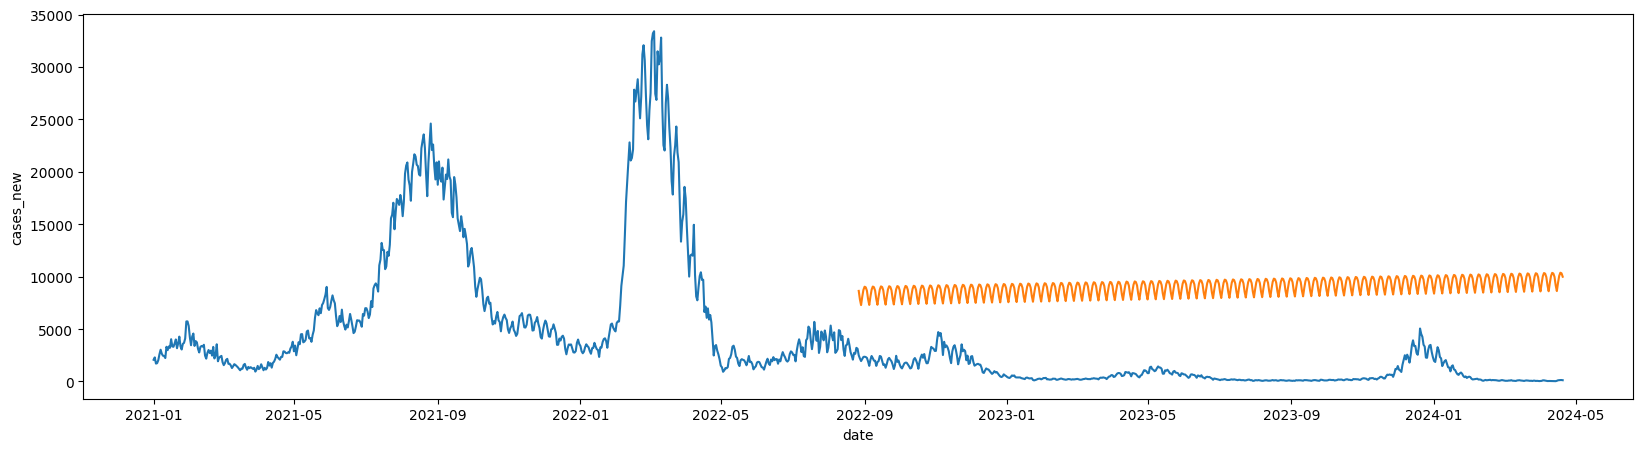

In [112]:
vis_df = df.copy()
vis_df.index = pd.to_datetime(vis_df.index)
plt.figure(figsize=(20,5))
sns.lineplot(vis_df['cases_new'])
sns.lineplot(forecastProphet['yhat'])